In [1]:
import torch as th
from active_critic.learner.active_critic_learner import ActiveCriticLearner, ACLScores
from active_critic.learner.active_critic_args import ActiveCriticLearnerArgs
from active_critic.policy.active_critic_policy import ActiveCriticPolicy
from active_critic.utils.gym_utils import make_dummy_vec_env, make_vec_env, parse_sampled_transitions, sample_expert_transitions, DummyExtractor, new_epoch_reach, sample_new_episode
from active_critic.utils.pytorch_utils import make_part_obs_data, count_parameters, build_tf_horizon_mask
from active_critic.utils.dataset import DatasetAC
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from active_critic.utils.dataset import DatasetAC
from active_critic.model_src.whole_sequence_model import (
    WholeSequenceModel)
from active_critic.model_src.transformer import (
    ModelSetup)
from active_critic.policy.active_critic_policy import ActiveCriticPolicySetup, ActiveCriticPolicy
from active_critic.model_src.state_model import *


from gym import Env
th.manual_seed(0)

def make_acps(seq_len, extractor, new_epoch, batch_size = 2, device='cpu', horizon = 0):
    acps = ActiveCriticPolicySetup()
    acps.device=device
    acps.epoch_len=seq_len
    acps.extractor=extractor
    acps.new_epoch=new_epoch
    acps.opt_steps=100
    acps.inference_opt_lr = 1e-1
    acps.optimizer_class = th.optim.Adam
    acps.optimize = True
    acps.batch_size = batch_size
    acps.pred_mask = build_tf_horizon_mask(seq_len=seq_len, horizon=horizon, device=device)
    acps.opt_mask = th.zeros([seq_len, 1], device=device, dtype=bool)
    acps.opt_mask[:,-1] = 1
    acps.opt_goal = True
    return acps

def setup_opt_state(batch_size, seq_len, device='cpu'):
    num_cpu = 1
    env, expert = make_vec_env('reach', num_cpu, seq_len=seq_len)
    d_output = env.action_space.shape[0]
    embed_dim = 20
    lr = 1e-3

    actor_args = StateModelArgs()
    actor_args.arch = [200, 200, env.action_space.shape[0]]
    actor_args.device = device
    actor_args.lr = lr
    actor = StateModel(args=actor_args)

    critic_args = StateModelArgs()
    critic_args.arch = [200, 200, 1]
    critic_args.device = device
    critic_args.lr = lr
    critic = StateModel(args=critic_args)

    inv_critic_args = StateModelArgs()
    inv_critic_args.arch = [200, 200, embed_dim + env.action_space.shape[0]]
    inv_critic_args.device = device
    inv_critic_args.lr = lr
    inv_critic = StateModel(args=inv_critic_args)

    emitter_args = StateModelArgs()
    emitter_args.arch = [200, 200, embed_dim]
    emitter_args.device = device
    emitter_args.lr = lr
    emitter = StateModel(args=emitter_args)

    predictor_args = StateModelArgs()
    predictor_args.arch = [200, 200, embed_dim]
    predictor_args.device = device
    predictor_args.lr = lr
    predictor = StateModel(args=emitter_args)


    acps = make_acps(
        seq_len=seq_len, extractor=DummyExtractor(), new_epoch=new_epoch_reach, device=device, batch_size=batch_size)
    acps.clip = True
    ac = ActiveCriticPolicy(observation_space=env.observation_space, 
                            action_space=env.action_space,
                            actor=actor,
                            critic=critic,
                            predictor=predictor,
                            emitter=emitter,
                            inverse_critic=inv_critic,
                            acps=acps)
    return ac, acps, batch_size, seq_len, env, expert


def make_acl():
    device = 'cpu'
    acla = ActiveCriticLearnerArgs()
    acla.data_path = '/home/hendrik/Documents/master_project/LokalData/TransformerImitationLearning/'
    acla.device = device
    acla.extractor = DummyExtractor()
    acla.imitation_phase = False
    acla.logname = 'reach_plot_embedding'
    acla.tboard = True
    acla.batch_size = 32
    acla.validation_episodes = 1
    acla.training_epsiodes = 1
    acla.actor_threshold = 1e-2
    acla.critic_threshold = 1e-2
    acla.predictor_threshold = 1e-2
    acla.num_cpu = 1

    batch_size = 2
    seq_len = 5
    ac, acps, batch_size, seq_len, env, expert= setup_opt_state(device=device, batch_size=batch_size, seq_len=seq_len)
    
    acps.opt_steps = 2
    acla.val_every = 1
    acla.add_data_every = 1

    

    eval_env, expert = make_vec_env('reach', num_cpu=acla.num_cpu, seq_len=seq_len)
    acl = ActiveCriticLearner(ac_policy=ac, env=env, eval_env=eval_env, network_args_obj=acla)
    return acl, env, expert, seq_len, device
acl, env, expert, seq_len, device = make_acl()


2022-11-03 16:33:07.161914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hendrik/miniconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/miniconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/miniconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/miniconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
 

In [10]:
import torch as th

In [52]:
from cmath import inf


a = th.tensor([float('nan'), 0], requires_grad=True)
with th.no_grad():
    th.nan_to_num(a, out=a)

In [53]:
a

tensor([0., 0.], requires_grad=True)

In [54]:
((a-1)**2).mean().backward()

In [55]:
a.grad

tensor([-1., -1.])

In [2]:
'''transitions = sample_expert_transitions(
    policy=expert.predict, env=env, episodes=2)

exp_actions, exp_observations, exp_rewards = parse_sampled_transitions(
    transitions=transitions, extractor=DummyExtractor(), device=device)
imitation_data = DatasetAC(device=device)
imitation_data.onyl_positiv = False
imitation_data.add_data(obsv=exp_observations, actions=exp_actions, reward=exp_rewards)
acl.setDatasets(train_data=imitation_data)'''

'transitions = sample_expert_transitions(\n    policy=expert.predict, env=env, episodes=2)\n\nexp_actions, exp_observations, exp_rewards = parse_sampled_transitions(\n    transitions=transitions, extractor=DummyExtractor(), device=device)\nimitation_data = DatasetAC(device=device)\nimitation_data.onyl_positiv = False\nimitation_data.add_data(obsv=exp_observations, actions=exp_actions, reward=exp_rewards)\nacl.setDatasets(train_data=imitation_data)'

Sampling transitions. 1


/home/hendrik/Documents/MasterProjct/ActiveCritic/src/active_critic/utils/gym_utils.py:187: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  actions = th.tensor(actions, dtype=th.float, device=device)


Sampling transitions. 1
/home/hendrik/Documents/master_project/LokalData/TransformerImitationLearning/reach_plot_embedding/best_validation
Success Rate: 0.0
Reward: 0.130803182721138
training samples: 1
Sampling transitions. 1
Sampling transitions. 1
/home/hendrik/Documents/master_project/LokalData/TransformerImitationLearning/reach_plot_embedding/best_validation
Success Rate: 0.0
Reward: 0.14791317284107208
training samples: 2
Sampling transitions. 1
Sampling transitions. 1
Success Rate: 0.0
Reward: 0.1465771347284317
training samples: 3
Sampling transitions. 1
Sampling transitions. 1
/home/hendrik/Documents/master_project/LokalData/TransformerImitationLearning/reach_plot_embedding/best_validation
Success Rate: 0.0
Reward: 0.15738755464553833
training samples: 4
Sampling transitions. 1
Sampling transitions. 1
Success Rate: 0.0
Reward: 0.15403731167316437
training samples: 5
Sampling transitions. 1
Sampling transitions. 1
Success Rate: 0.0
Reward: 0.12032973021268845
training samples: 

Process ForkServerProcess-1:
Traceback (most recent call last):
  File "/home/hendrik/miniconda3/envs/ac/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/hendrik/miniconda3/envs/ac/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hendrik/miniconda3/envs/ac/lib/python3.10/site-packages/stable_baselines3/common/vec_env/subproc_vec_env.py", line 27, in _worker
    cmd, data = remote.recv()
  File "/home/hendrik/miniconda3/envs/ac/lib/python3.10/multiprocessing/connection.py", line 255, in recv
    buf = self._recv_bytes()
  File "/home/hendrik/miniconda3/envs/ac/lib/python3.10/multiprocessing/connection.py", line 419, in _recv_bytes
    buf = self._recv(4)
  File "/home/hendrik/miniconda3/envs/ac/lib/python3.10/multiprocessing/connection.py", line 384, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Exception ignored in: <function TransformNode.set_childre

Success Rate: 0.0
Reward: 0.1127292811870575
training samples: 25
Sampling transitions. 1


BrokenPipeError: [Errno 32] Broken pipe

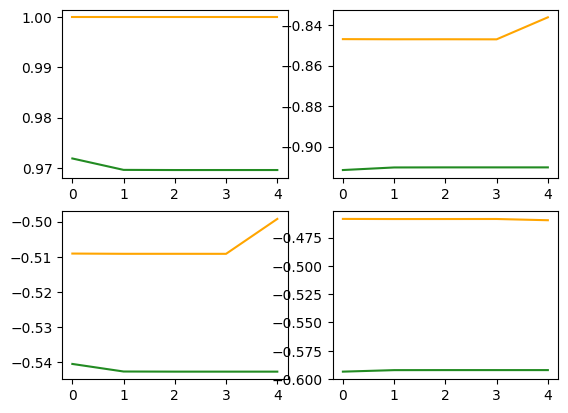

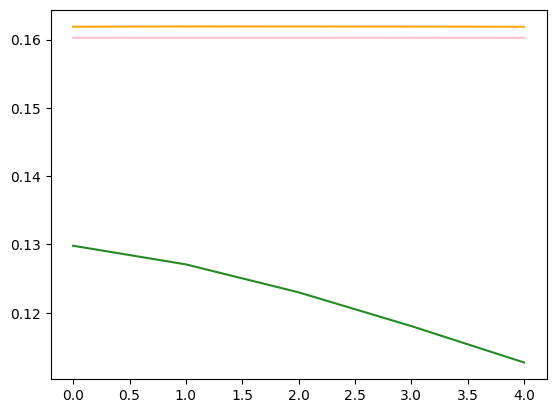

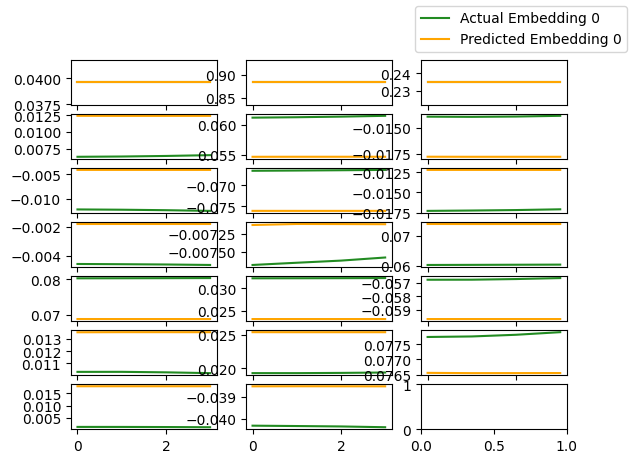

In [3]:
acl.train(epochs=10000)

In [ ]:
count_parameters(acl.policy)

In [ ]:
a = th.ones([3,3,3])
b = th.ones([3,3])

c = th.cat((a, b[:, None]), dim=-1)

RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 3 but got size 1 for tensor number 1 in the list.